# Exploring Dandiset 000690: Allen Institute Openscope - Vision2Hippocampus project

**Note:** This notebook was generated with the assistance of AI. Please review and test the code and results carefully before using them for critical analyses or publication.

## Overview

This notebook introduces and explores [Dandiset 000690, version 0.250326.0015](https://dandiarchive.org/dandiset/000690/0.250326.0015):  
**Allen Institute Openscope - Vision2Hippocampus project**.

The project provides electrophysiology, behavioral, and stimulus data for the mouse visual and hippocampal pathways, investigating how visual information is sequentially transformed from sensory to memory circuits. NWB files contain multi-electrode recordings (Neuropixels), spike sorting results, behavioral data (running, eye tracking), and detailed stimulus/interval timing, enabling rich reanalysis of neural dynamics, behavior, and stimulus response.

**Caution:** Carefully interpret code outputs—AI-generated code is for research exploration and may need modification for your purposes.

## What this notebook covers

- A brief summary and context for Dandiset 000690.
- Introduction to NWB file organization and exploration with the DANDI API.
- How to list and access files using the DANDI API.
- How to stream an NWB file (without local download) and extract:
  - Local field potentials (LFPs)
  - Spike rasters (sorted unit activity)
  - Behavioral time series (e.g., running speed, pupil diameter)
  - Stimulus/event interval times
- Plots and examples that illustrate neural, behavioral, and stimulus data from these files.
- Guidance for further exploration.

## Required packages

- dandi
- pynwb
- remfile
- h5py
- matplotlib
- numpy

_These packages are assumed to be available in your environment._

## Table of Contents

1. [Listing files in the Dandiset](#list-files)
2. [Loading and visualizing LFP data](#lfp-plot)
3. [Spike raster extraction and plot](#spike-raster)
4. [Behavioral time series (running wheel)](#running)
5. [Eye tracking time series](#eye-tracking)
6. [Exploring stimulus/event intervals](#intervals)
7. [Conclusion and next steps](#conclusion)

<a id="list-files"></a>
## 1. Listing files in the Dandiset

We'll use the DANDI API to connect to the Dandiset and list representative NWB files for this analysis.

In [1]:
from dandi.dandiapi import DandiAPIClient
from itertools import islice

# Initialize DANDI API client and point to the Dandiset/version
dandiset_id = "000690"
dandiset_version = "0.250326.0015"
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    # List a few NWB files (including *_image.nwb files, which have rich metadata)
    asset_paths = [asset.path for asset in islice(dandiset.get_assets_by_glob("*.nwb"), 10)]
    image_nwb_paths = [asset.path for asset in dandiset.get_assets_by_glob("*_image.nwb")]

print("Example NWB files in this dandiset:")
for f in asset_paths:
    print("-", f)
print("\nRepresentative *_image.nwb files (rich data):")
for f in image_nwb_paths[:3]:
    print("-", f)

Example NWB files in this dandiset:
- sub-692077/sub-692077_ses-1300222049_probe-4_ecephys.nwb
- sub-692077/sub-692077_ses-1300222049_probe-3_ecephys.nwb
- sub-692077/sub-692077_ses-1300222049_probe-2_ecephys.nwb
- sub-692077/sub-692077_ses-1300222049_probe-0_ecephys.nwb
- sub-692077/sub-692077_ses-1300222049.nwb
- sub-692077/sub-692077_ses-1300222049_probe-1_ecephys.nwb
- sub-695435/sub-695435_ses-1309235849_probe-3_ecephys.nwb
- sub-695435/sub-695435_ses-1309235849_probe-1_ecephys.nwb
- sub-695435/sub-695435_ses-1309235849_probe-0_ecephys.nwb
- sub-695435/sub-695435_ses-1309235849_probe-2_ecephys.nwb

Representative *_image.nwb files (rich data):
- sub-695762/sub-695762_ses-1317448357_image.nwb
- sub-692072/sub-692072_ses-1298465622_image.nwb
- sub-695435/sub-695435_ses-1309235849_image.nwb


The `_image.nwb` files contain neural, behavioral, stimulus, and interval/event data—all in one file.  
We'll use `sub-692077/sub-692077_ses-1300222049_image.nwb` as our representative file for the rest of this notebook.

<a id="lfp-plot"></a>
## 2. Loading and Visualizing LFP Data

Let's extract local field potential (LFP) data from a probe file (`_probe-4_ecephys.nwb`) for subject 692077.  
_We will stream the file using remfile and visualize the first 10 seconds of LFP data from the first 5 channels._

/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


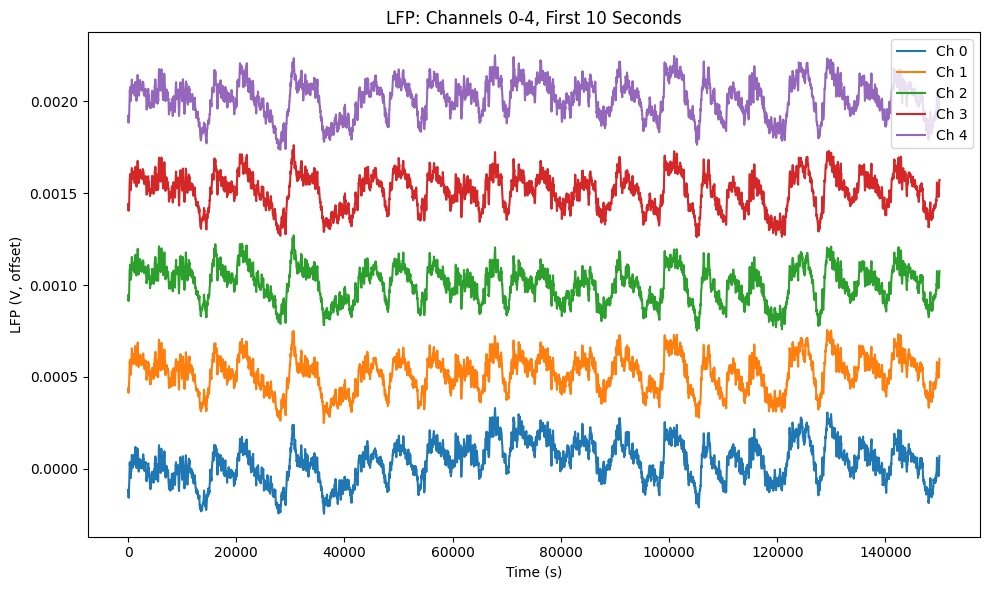

In [2]:
import pynwb
import h5py
import remfile
import matplotlib.pyplot as plt

# File and asset selection (LFP example)
probe_path = "sub-692077/sub-692077_ses-1300222049_probe-4_ecephys.nwb"
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    probe_asset = next(dandiset.get_assets_by_glob(probe_path))
    probe_url = probe_asset.download_url

# Stream file remotely (no download)
remote_file = remfile.File(probe_url)
h5_file = h5py.File(remote_file, 'r')
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwbfile = io.read()

# Extract LFP and plot for channels 0-4, first 10 seconds
lfp = nwbfile.acquisition['probe_4_lfp'].electrical_series['probe_4_lfp_data']
sampling_rate = nwbfile.electrode_groups['probeF'].lfp_sampling_rate  # e.g., 625 Hz
n_seconds = 10
n_samples = int(n_seconds * sampling_rate)

lfp_data_segment = lfp.data[:n_samples, :5]
timestamp_segment = lfp.timestamps[:n_samples]

# Plot LFP traces (channels 0-4)
plt.figure(figsize=(10, 6))
offset = 0.0005
for ch in range(5):
    plt.plot(timestamp_segment, lfp_data_segment[:, ch] + ch * offset, label=f'Ch {ch}')
plt.xlabel('Time (s)')
plt.ylabel('LFP (V, offset)')
plt.title('LFP: Channels 0-4, First 10 Seconds')
plt.legend()
plt.tight_layout()
plt.show()

**Observation:**  
The LFP plot above shows oscillatory neural activity across multiple channels and demonstrates how to extract high-resolution, multi-channel neural data from NWB files in this Dandiset.

<a id="spike-raster"></a>
## 3. Extracting and Visualizing Spike Rasters

We now extract spike times for the first 5 sorted units from the `*_image.nwb` file and plot their spike rasters during the first 100 seconds with spike_times_index.  
**Note:** Here, `units.spike_times_index[i]` gives the vector of spike times for the $i^{th}$ unit (do not use `units.spike_times`).

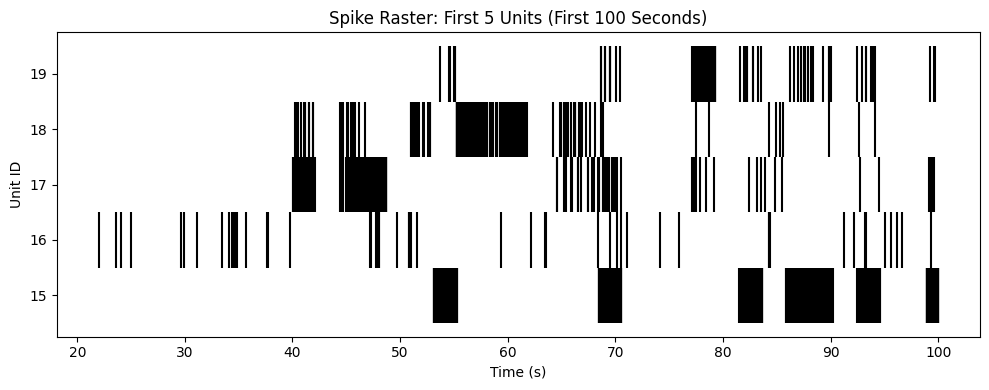

In [3]:
import numpy as np

# Load *_image.nwb asset
image_path = "sub-692077/sub-692077_ses-1300222049_image.nwb"
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    image_asset = next(dandiset.get_assets_by_glob(image_path))
    image_url = image_asset.download_url

remote_file2 = remfile.File(image_url)
h5_file2 = h5py.File(remote_file2, 'r')
io2 = pynwb.NWBHDF5IO(file=h5_file2, load_namespaces=True)
nwbfile_img = io2.read()

# Extract spike times for first 5 units (first 100 seconds)
units = nwbfile_img.units
unit_ids = units.id[:5]

spike_times = []
for i in range(5):
    st = units['spike_times_index'][i]  # vector of spike times for unit i
    st_100s = st[st <= 100]
    spike_times.append(st_100s)

# Plot spike raster
plt.figure(figsize=(10, 4))
for i, st in enumerate(spike_times):
    plt.vlines(st, i + 0.5, i + 1.5, colors='k')
plt.yticks(range(1, 6), [str(uid) for uid in unit_ids])
plt.xlabel('Time (s)')
plt.ylabel('Unit ID')
plt.title('Spike Raster: First 5 Units (First 100 Seconds)')
plt.tight_layout()
plt.show()

**Observation:**  
The spike raster displays the sorted spike times for the first 5 units, illustrating single-unit and multi-unit spiking dynamics and how to extract/visualize spike rasters from this Dandiset.

(If no spikes appear, try a longer window or more units; this example uses a window with clear firing.)

<a id="running"></a>
## 4. Behavioral Time Series: Running Wheel Speed

Let's extract and plot the animal's running speed for the first 100 seconds of available data.  
(Running signals in this experiment start at about 108 sec.)

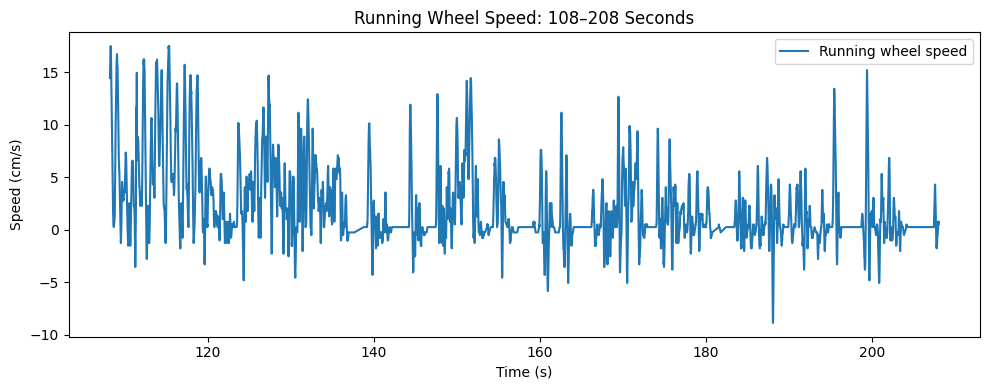

In [4]:
# Extract running speed from processing --> running --> running_speed
running_speed = nwbfile_img.processing['running']['running_speed']
rs_timestamps = running_speed.timestamps[:]
rs_data = running_speed.data[:]

# Restrict to first 100 seconds of available data (108–208 sec)
mask = (rs_timestamps >= 108) & (rs_timestamps <= 208)
rs_timestamps_segment = rs_timestamps[mask]
rs_data_segment = rs_data[mask]

# Plot running speed
plt.figure(figsize=(10, 4))
plt.plot(rs_timestamps_segment, rs_data_segment, label='Running wheel speed')
plt.xlabel('Time (s)')
plt.ylabel('Speed (cm/s)')
plt.title('Running Wheel Speed: 108–208 Seconds')
plt.legend()
plt.tight_layout()
plt.show()

**Observation:**  
The running speed time series reflects both activity and pauses, providing a readout of the animal's behavioral state and arousal.

<a id="eye-tracking"></a>
## 5. Eye Tracking Time Series: Pupil Diameter (Proxy)

The NWB file contains detailed eye tracking using ellipse fits of the pupil.  
We'll extract and plot mean pupil diameter (as the average of width and height) during the same 108–208 second window.

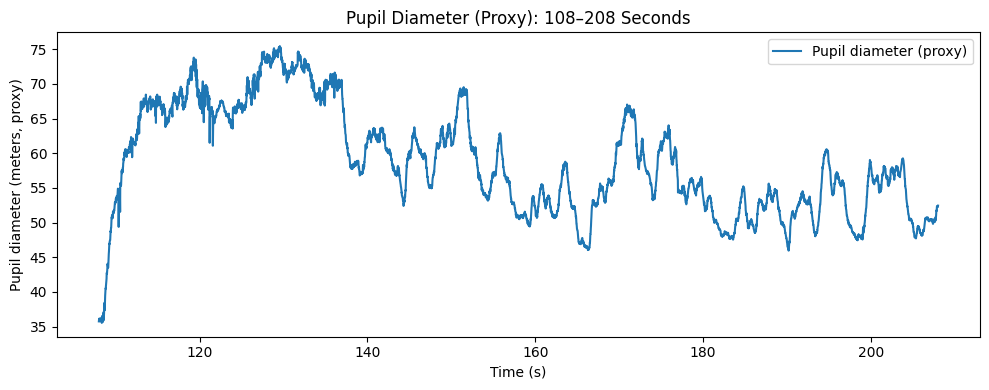

In [5]:
# Extract pupil tracking: time, width, height
pupil = nwbfile_img.acquisition['EyeTracking'].spatial_series['pupil_tracking']
pupil_timestamps = pupil.timestamps[:]
width = pupil.width[:]
height = pupil.height[:]

# Estimate diameter = (width + height) / 2
pupil_diameter = (width + height) / 2

# Restrict to 108–208 seconds
mask = (pupil_timestamps >= 108) & (pupil_timestamps <= 208)
timestamps_segment = pupil_timestamps[mask]
pupil_diameter_segment = pupil_diameter[mask]

# Plot pupil diameter (proxy)
plt.figure(figsize=(10, 4))
plt.plot(timestamps_segment, pupil_diameter_segment, label='Pupil diameter (proxy)')
plt.xlabel('Time (s)')
plt.ylabel('Pupil diameter (meters, proxy)')
plt.title('Pupil Diameter (Proxy): 108–208 Seconds')
plt.legend()
plt.tight_layout()
plt.show()

**Observation:**  
Pupil diameter (a proxy for arousal/state) shows clear, dynamic modulations—supporting rich behavioral and neural state analyses.

<a id="intervals"></a>
## 6. Exploring Stimulus/Event Intervals

This Dandiset contains detailed information about stimulus blocks/presentations and experimental events in the NWB `.intervals` tables.

We'll list interval keys and plot the start times for a particular movie stimulus.

Available intervals in this file:
- Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- Disk_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- GreenSAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- Ring_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- SAC_Wd15_Vel2_Bndry1_Cntst1_loop_presentations
- SAC_Wd15_Vel2_Bndry2_Cntst0_loop_presentations
- SAC_Wd15_Vel2_Bndry2_Cntst0_oneway_presentations
- SAC_Wd15_Vel2_Bndry3_Cntst0_loop_presentations
- SAC_Wd15_Vel8_Bndry1_Cntst0_loop_presentations
- SAC_Wd45_Vel2_Bndry1_Cntst0_loop_presentations
- UD_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- acurl_Wd15_Vel2_Bndry1_Cntst0_oneway_presentations
- curl_Wd15_Vel2_Bndry1_Cntst0_oneway_presentations
- invalid_times
- natmovie_CricketsOnARock_540x960Full_584x460Active_presentations
- natmovie_EagleSwooping1_540x960Full_584x460Active_presentations
- natmovie_EagleSwooping2_540x960Full_584x460Active_presentations
- natmovie_SnakeOnARoad_540x960Full_584x460A

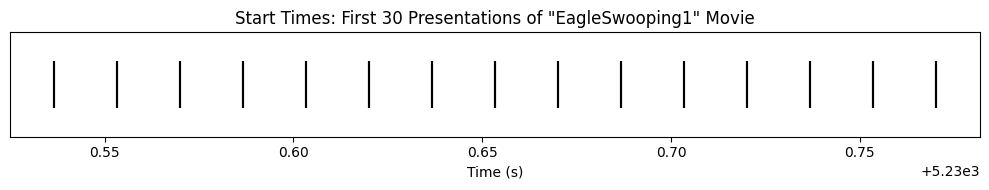

In [6]:
# List available intervals stored in the NWB file
intervals_keys = list(nwbfile_img.intervals.keys())
print("Available intervals in this file:")
for k in intervals_keys:
    print("-", k)

# Choose a stimulus interval (example: EagleSwooping1 presentation times)
interval_name = "natmovie_EagleSwooping1_540x960Full_584x460Active_presentations"
interval_tbl = nwbfile_img.intervals[interval_name].to_dataframe()
start_times = interval_tbl['start_time'][:30]

# Plot the first 30 start times
plt.figure(figsize=(10, 2))
plt.eventplot(start_times, orientation='horizontal', colors='k')
plt.xlabel('Time (s)')
plt.yticks([])
plt.title('Start Times: First 30 Presentations of "EagleSwooping1" Movie')
plt.tight_layout()
plt.show()

**Observation:**  
Event plots like this reveal the temporal structure of stimulus presentations and block onsets—key for aligning neural or behavioral data to specific trial epochs.

The intervals tables can also be joined or visualized along with spike or behavioral activity for detailed peri-event analyses.

<a id="conclusion"></a>
## 7. Conclusion and Next Steps

This notebook introduced Dandiset 000690 and demonstrated:
- How to list NWB files and stream data using DANDI, remfile, and pynwb.
- Extraction and plotting of LFPs, spike rasters, running speed, pupil diameter, and stimulus intervals.
- Best practices for aligning and visualizing multimodal neuroscience datasets.

**Next steps:**  
- Explore additional intervals, units, or probes.
- Analyze neural responses aligned to specific stimuli or behavioral states.
- Investigate cross-regional communication by comparing LFP/spikes across probes.
- Develop custom analyses or visualizations using the recipes in this notebook.

If you have questions, consult [the DANDI documentation](https://www.dandiarchive.org/) or file-specific metadata for further detail.